In [69]:
from new_ssd_network import *
from new_ssd_dataset import *
import csv
import torch
from tqdm import tqdm
import time

In [70]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
device = "cpu"

In [61]:
train_annotations = pd.read_csv(rf"C:\Users\izaol\fridge_food\jedzenie\train\labels\_annotations.csv")
valid_annotations = pd.read_csv(rf"C:\Users\izaol\fridge_food\jedzenie\valid\labels\_annotations.csv")
test_annotations = pd.read_csv(rf"C:\Users\izaol\fridge_food\jedzenie\test\labels\_annotations.csv")

# Concatenate the dataframes to find unique product names across all sets
all_annotations = pd.concat([train_annotations, valid_annotations, test_annotations])

# Get unique product names
unique_products = all_annotations['class'].unique()

# Create a mapping dictionary
product_to_number = {product: idx for idx, product in enumerate(unique_products)}

# Apply the mapping to each set
for df in [train_annotations, valid_annotations, test_annotations]:
    df['class'] = 0

# Save the updated annotations back to files if needed
train_annotations.to_csv('train_annotations_mapped.csv', index=False)
valid_annotations.to_csv('valid_annotations_mapped.csv', index=False)
test_annotations.to_csv('test_annotations_mapped.csv', index=False)

In [62]:
product_to_number

{'lemon': 0, 'mustard': 1, 'butter': 2, 'ketchup': 3}

In [63]:
with open(rf"C:\Users\izaol\fridge_food\jedzenie\train\labels\_annotations.csv", 'r') as f:
    
    label_to_id = {}
    class_names = []
    label_counter = 0
    
    reader = csv.DictReader(f)
    for row in reader:
        print(row)
        img_filename = row['filename']
        class_label = row['class']
    
        # Przypisz nowy numer etykiety, jeśli jeszcze nie istnieje
        if class_label not in label_to_id:
            label_to_id[class_label] = label_counter
            label_counter += 1
            class_names.append(class_label)

{'filename': '20241103_122712_jpg.rf.0532eff9320967473b6392be4a85849e.jpg', 'width': '300', 'height': '300', 'class': 'lemon', 'xmin': '54', 'ymin': '75', 'xmax': '109', 'ymax': '121'}
{'filename': '20241103_122712_jpg.rf.0532eff9320967473b6392be4a85849e.jpg', 'width': '300', 'height': '300', 'class': 'mustard', 'xmin': '162', 'ymin': '60', 'xmax': '256', 'ymax': '186'}
{'filename': '20241103_122712_jpg.rf.0532eff9320967473b6392be4a85849e.jpg', 'width': '300', 'height': '300', 'class': 'butter', 'xmin': '90', 'ymin': '243', 'xmax': '146', 'ymax': '289'}
{'filename': '20241103_122712_jpg.rf.0532eff9320967473b6392be4a85849e.jpg', 'width': '300', 'height': '300', 'class': 'ketchup', 'xmin': '183', 'ymin': '243', 'xmax': '244', 'ymax': '300'}
{'filename': '20241103_123054_jpg.rf.063610cb9f6fdeafa6d8558291f05704.jpg', 'width': '300', 'height': '300', 'class': 'mustard', 'xmin': '180', 'ymin': '164', 'xmax': '199', 'ymax': '196'}
{'filename': '20241103_123054_jpg.rf.063610cb9f6fdeafa6d855829

In [64]:
label_counter

4

In [65]:
id_to_class = {i: v for i, v in enumerate(class_names)}

In [66]:
EPOCH = 20
LR = 1e-3
BS = 20
momentum = 0.9  # momentum
weight_decay = 5e-4  # weight decay
print_feq = 100

In [72]:
model = SSD(n_classes=2).to(device)  # all cards + background
criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=momentum, weight_decay=weight_decay)  

C:\Users\izaol\fridge_food\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\izaol\fridge_food\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Loaded base model.


C:\Users\izaol\fridge_food\venv\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [73]:
train_img_paths = sorted(os.listdir("C:/Users/izaol/fridge_food/jedzenie/train/images/"))
train_annot_paths = sorted(os.listdir("C:/Users/izaol/fridge_food/jedzenie/train/labels/"))

valid_img_paths = sorted(os.listdir("C:/Users/izaol/fridge_food/jedzenie/valid/images/"))
valid_annot_paths = sorted(os.listdir("C:/Users/izaol/fridge_food/jedzenie/valid/labels/"))

In [74]:
train_ds = SSDDateset(train_img_paths, 'train_annotations_mapped.csv', subset='train')
train_dl = DataLoader(train_ds, batch_size=BS, shuffle=True, collate_fn=train_ds.collate_fn)

In [75]:
valid_ds = SSDDateset(valid_img_paths, 'valid_annotations_mapped.csv', subset='valid')
valid_dl = DataLoader(valid_ds, batch_size=BS, shuffle=True, collate_fn=valid_ds.collate_fn)

In [76]:
def train_model(model, EPOCH, device, train_dl, criterion, optimizer, valid_dl):
    for epoch in range(1, EPOCH+1):
        model.train()
        train_loss = []
        for step, (img, boxes, labels) in enumerate(train_dl):
            time_1 = time.time()
            img = img.to(device)
    
            boxes = [box.to(device) for box in boxes]
    
            labels = [label.to(device) for label in labels]
            
            pred_loc, pred_sco = model(img)
            
            loss = criterion(pred_loc, pred_sco, boxes, labels)
            
            # Backward propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            train_loss.append(loss.item())
            if step % print_feq == 0:
                print('epoch:', epoch, 
                      '\tstep:', step+1, '/', len(train_dl) + 1,
                      '\ttrain loss:', '{:.4f}'.format(loss.item()),
                      '\ttime:', '{:.4f}'.format((time.time()-time_1)*print_feq), 's')
        
        model.eval()
        valid_loss = []
        with torch.no_grad():
            for step, (img, boxes, labels) in enumerate(tqdm(valid_dl)):
                img = img.to(device)
                boxes = [box.to(device) for box in boxes]
                labels = [label.to(device) for label in labels]
                pred_loc, pred_sco = model(img)
                loss = criterion(pred_loc, pred_sco, boxes, labels)
                valid_loss.append(loss.item())
            
        print('epoch:', epoch, '/', EPOCH+1,
                '\ttrain loss:', '{:.4f}'.format(np.mean(train_loss)),
                '\tvalid loss:', '{:.4f}'.format(np.mean(valid_loss)))

In [78]:
model1 = SSD(n_classes=2).to(device)  # all cards + background
criterion1 = MultiBoxLoss(priors_cxcy=model.priors_cxcy).to(device)
optimizer1 = torch.optim.SGD(model.parameters(), lr=LR, momentum=momentum, weight_decay=weight_decay)  

C:\Users\izaol\fridge_food\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\izaol\fridge_food\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Loaded base model.


C:\Users\izaol\fridge_food\venv\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [79]:
train_model(model1, 50, device, train_dl, criterion1, optimizer1, valid_dl)

epoch: 1 	step: 1 / 9 	train loss: 9227.1260 	time: 2024.8076 s


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


epoch: 1 / 51 	train loss: 9492.6554 	valid loss: 9605.6670
epoch: 2 	step: 1 / 9 	train loss: 9881.5371 	time: 2147.4996 s


100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


epoch: 2 / 51 	train loss: 9523.0935 	valid loss: 9605.6670
epoch: 3 	step: 1 / 9 	train loss: 10129.2461 	time: 1989.4219 s


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


epoch: 3 / 51 	train loss: 9519.9893 	valid loss: 9605.6670
epoch: 4 	step: 1 / 9 	train loss: 9589.8838 	time: 1957.8000 s


100%|██████████| 1/1 [00:02<00:00,  2.43s/it]


epoch: 4 / 51 	train loss: 9576.9398 	valid loss: 9605.6670
epoch: 5 	step: 1 / 9 	train loss: 9163.1445 	time: 1974.6995 s


100%|██████████| 1/1 [00:02<00:00,  2.49s/it]


epoch: 5 / 51 	train loss: 9513.2316 	valid loss: 9605.6670
epoch: 6 	step: 1 / 9 	train loss: 9738.5293 	time: 1976.5002 s


100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


epoch: 6 / 51 	train loss: 9494.8766 	valid loss: 9605.6670
epoch: 7 	step: 1 / 9 	train loss: 9328.2588 	time: 1968.9000 s


100%|██████████| 1/1 [00:02<00:00,  2.91s/it]


epoch: 7 / 51 	train loss: 9466.6244 	valid loss: 9605.6670
epoch: 8 	step: 1 / 9 	train loss: 9263.5420 	time: 2238.8996 s


100%|██████████| 1/1 [00:02<00:00,  2.65s/it]


epoch: 8 / 51 	train loss: 9559.0306 	valid loss: 9605.6660
epoch: 9 	step: 1 / 9 	train loss: 9616.6816 	time: 1964.5995 s


100%|██████████| 1/1 [00:02<00:00,  2.49s/it]


epoch: 9 / 51 	train loss: 9512.8591 	valid loss: 9605.6670
epoch: 10 	step: 1 / 9 	train loss: 9227.7119 	time: 1951.6997 s


100%|██████████| 1/1 [00:02<00:00,  2.45s/it]


epoch: 10 / 51 	train loss: 9515.4800 	valid loss: 9605.6660
epoch: 11 	step: 1 / 9 	train loss: 9470.3154 	time: 1948.8997 s


100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


epoch: 11 / 51 	train loss: 9509.2656 	valid loss: 9605.6660
epoch: 12 	step: 1 / 9 	train loss: 8969.4316 	time: 1933.8231 s


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


epoch: 12 / 51 	train loss: 9535.0328 	valid loss: 9605.6670
epoch: 13 	step: 1 / 9 	train loss: 10032.3877 	time: 1939.8003 s


100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


epoch: 13 / 51 	train loss: 9538.5499 	valid loss: 9605.6670
epoch: 14 	step: 1 / 9 	train loss: 9481.6318 	time: 1950.7146 s


100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


epoch: 14 / 51 	train loss: 9492.8563 	valid loss: 9605.6670
epoch: 15 	step: 1 / 9 	train loss: 9618.2676 	time: 1917.9001 s


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


epoch: 15 / 51 	train loss: 9552.9957 	valid loss: 9605.6670
epoch: 16 	step: 1 / 9 	train loss: 9455.6768 	time: 1942.7492 s


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


epoch: 16 / 51 	train loss: 9471.8861 	valid loss: 9605.6660
epoch: 17 	step: 1 / 9 	train loss: 9502.5293 	time: 1962.3996 s


100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


epoch: 17 / 51 	train loss: 9512.2333 	valid loss: 9605.6670
epoch: 18 	step: 1 / 9 	train loss: 9419.5723 	time: 1969.1519 s


100%|██████████| 1/1 [00:02<00:00,  2.49s/it]


epoch: 18 / 51 	train loss: 9544.1205 	valid loss: 9605.6689
epoch: 19 	step: 1 / 9 	train loss: 9739.9551 	time: 1945.4998 s


100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


epoch: 19 / 51 	train loss: 9500.3263 	valid loss: 9605.6660
epoch: 20 	step: 1 / 9 	train loss: 9802.7422 	time: 1958.7000 s


100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


epoch: 20 / 51 	train loss: 9479.1831 	valid loss: 9605.6689
epoch: 21 	step: 1 / 9 	train loss: 9883.2822 	time: 1974.6094 s


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


epoch: 21 / 51 	train loss: 9494.2509 	valid loss: 9605.6670
epoch: 22 	step: 1 / 9 	train loss: 9433.6016 	time: 1977.0996 s


100%|██████████| 1/1 [00:02<00:00,  2.69s/it]


epoch: 22 / 51 	train loss: 9508.2976 	valid loss: 9605.6660
epoch: 23 	step: 1 / 9 	train loss: 9746.0449 	time: 2010.5701 s


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


epoch: 23 / 51 	train loss: 9506.8035 	valid loss: 9605.6660
epoch: 24 	step: 1 / 9 	train loss: 9554.8730 	time: 2194.9998 s


100%|██████████| 1/1 [00:02<00:00,  2.71s/it]


epoch: 24 / 51 	train loss: 9584.3303 	valid loss: 9605.6660
epoch: 25 	step: 1 / 9 	train loss: 9608.2578 	time: 1980.4999 s


100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


epoch: 25 / 51 	train loss: 9498.2917 	valid loss: 9605.6670
epoch: 26 	step: 1 / 9 	train loss: 9241.8887 	time: 1963.0000 s


100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


epoch: 26 / 51 	train loss: 9513.2004 	valid loss: 9605.6670
epoch: 27 	step: 1 / 9 	train loss: 9771.7754 	time: 1958.4995 s


100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


epoch: 27 / 51 	train loss: 9527.4994 	valid loss: 9605.6689
epoch: 28 	step: 1 / 9 	train loss: 9959.6738 	time: 1968.7002 s


100%|██████████| 1/1 [00:02<00:00,  2.49s/it]


epoch: 28 / 51 	train loss: 9462.1521 	valid loss: 9605.6670
epoch: 29 	step: 1 / 9 	train loss: 9788.0928 	time: 1949.8485 s


100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


epoch: 29 / 51 	train loss: 9576.7511 	valid loss: 9605.6660
epoch: 30 	step: 1 / 9 	train loss: 9426.4570 	time: 1928.5001 s


100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


epoch: 30 / 51 	train loss: 9475.4768 	valid loss: 9605.6670
epoch: 31 	step: 1 / 9 	train loss: 9698.9551 	time: 1963.4294 s


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


epoch: 31 / 51 	train loss: 9512.9128 	valid loss: 9605.6670
epoch: 32 	step: 1 / 9 	train loss: 9563.6582 	time: 1981.8993 s


100%|██████████| 1/1 [00:02<00:00,  2.65s/it]


epoch: 32 / 51 	train loss: 9476.0188 	valid loss: 9605.6660
epoch: 33 	step: 1 / 9 	train loss: 9704.0205 	time: 1978.5518 s


100%|██████████| 1/1 [00:02<00:00,  2.45s/it]


epoch: 33 / 51 	train loss: 9510.0852 	valid loss: 9605.6660
epoch: 34 	step: 1 / 9 	train loss: 9343.7607 	time: 1948.4958 s


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


epoch: 34 / 51 	train loss: 9544.7880 	valid loss: 9605.6660
epoch: 35 	step: 1 / 9 	train loss: 9540.6797 	time: 1929.8514 s


100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


epoch: 35 / 51 	train loss: 9422.3600 	valid loss: 9605.6670
epoch: 36 	step: 1 / 9 	train loss: 9475.2441 	time: 1954.6001 s


100%|██████████| 1/1 [00:02<00:00,  2.49s/it]


epoch: 36 / 51 	train loss: 9533.1146 	valid loss: 9605.6689
epoch: 37 	step: 1 / 9 	train loss: 9546.1240 	time: 1955.9279 s


100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


epoch: 37 / 51 	train loss: 9502.8116 	valid loss: 9605.6670
epoch: 38 	step: 1 / 9 	train loss: 9611.8848 	time: 1961.7999 s


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


epoch: 38 / 51 	train loss: 9500.9670 	valid loss: 9605.6670
epoch: 39 	step: 1 / 9 	train loss: 9821.0635 	time: 2074.3565 s


100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


epoch: 39 / 51 	train loss: 9551.4645 	valid loss: 9605.6670
epoch: 40 	step: 1 / 9 	train loss: 9553.3125 	time: 1963.7004 s


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


epoch: 40 / 51 	train loss: 9566.4897 	valid loss: 9605.6670
epoch: 41 	step: 1 / 9 	train loss: 9148.1689 	time: 1961.6997 s


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


epoch: 41 / 51 	train loss: 9555.8544 	valid loss: 9605.6660
epoch: 42 	step: 1 / 9 	train loss: 9428.7363 	time: 1969.6005 s


100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


epoch: 42 / 51 	train loss: 9502.3844 	valid loss: 9605.6660
epoch: 43 	step: 1 / 9 	train loss: 9086.6543 	time: 1945.1002 s


100%|██████████| 1/1 [00:02<00:00,  2.49s/it]


epoch: 43 / 51 	train loss: 9577.9222 	valid loss: 9605.6670
epoch: 44 	step: 1 / 9 	train loss: 9428.3418 	time: 1982.1903 s


100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


epoch: 44 / 51 	train loss: 9577.9500 	valid loss: 9605.6670
epoch: 45 	step: 1 / 9 	train loss: 10014.5127 	time: 1949.3999 s


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


epoch: 45 / 51 	train loss: 9583.0509 	valid loss: 9605.6670
epoch: 46 	step: 1 / 9 	train loss: 9249.2002 	time: 2030.6933 s


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


epoch: 46 / 51 	train loss: 9531.8271 	valid loss: 9605.6670
epoch: 47 	step: 1 / 9 	train loss: 9155.6016 	time: 1962.9996 s


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


epoch: 47 / 51 	train loss: 9511.6328 	valid loss: 9605.6670
epoch: 48 	step: 1 / 9 	train loss: 9355.1729 	time: 1946.2518 s


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


epoch: 48 / 51 	train loss: 9533.5823 	valid loss: 9605.6670
epoch: 49 	step: 1 / 9 	train loss: 9042.5098 	time: 1945.2998 s


100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


epoch: 49 / 51 	train loss: 9516.9188 	valid loss: 9605.6670
epoch: 50 	step: 1 / 9 	train loss: 9467.6680 	time: 1958.9242 s


100%|██████████| 1/1 [00:02<00:00,  2.61s/it]

epoch: 50 / 51 	train loss: 9621.3085 	valid loss: 9605.6670


In [80]:
model2 = SSD(n_classes=2).to(device)  # all cards + background
criterion2 = MultiBoxLoss(priors_cxcy=model.priors_cxcy).to(device)
optimizer2 = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=weight_decay)  

C:\Users\izaol\fridge_food\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\izaol\fridge_food\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Loaded base model.


C:\Users\izaol\fridge_food\venv\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [81]:
train_model(model2, 50, device, train_dl, criterion2, optimizer2, valid_dl)

epoch: 1 	step: 1 / 9 	train loss: 9370.3311 	time: 1942.1278 s


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


epoch: 1 / 51 	train loss: 9508.0895 	valid loss: 9605.5381
epoch: 2 	step: 1 / 9 	train loss: 9602.8857 	time: 2028.9971 s


100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


epoch: 2 / 51 	train loss: 9496.9613 	valid loss: 9605.5381
epoch: 3 	step: 1 / 9 	train loss: 9581.1680 	time: 1951.9997 s


100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


epoch: 3 / 51 	train loss: 9520.8306 	valid loss: 9605.5400
epoch: 4 	step: 1 / 9 	train loss: 9487.1182 	time: 1940.4002 s


100%|██████████| 1/1 [00:02<00:00,  2.43s/it]


epoch: 4 / 51 	train loss: 9492.5444 	valid loss: 9605.5400
epoch: 5 	step: 1 / 9 	train loss: 9738.2031 	time: 1962.5035 s


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


epoch: 5 / 51 	train loss: 9446.0494 	valid loss: 9605.5381
epoch: 6 	step: 1 / 9 	train loss: 8908.3408 	time: 1955.8000 s


100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


epoch: 6 / 51 	train loss: 9487.2976 	valid loss: 9605.5381
epoch: 7 	step: 1 / 9 	train loss: 9519.2900 	time: 1923.6555 s


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


epoch: 7 / 51 	train loss: 9575.8527 	valid loss: 9605.5381
epoch: 8 	step: 1 / 9 	train loss: 9455.3887 	time: 1894.0036 s


100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


epoch: 8 / 51 	train loss: 9553.9811 	valid loss: 9605.5381
epoch: 9 	step: 1 / 9 	train loss: 9344.7988 	time: 1913.0543 s


100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


epoch: 9 / 51 	train loss: 9564.9456 	valid loss: 9605.5400
epoch: 10 	step: 1 / 9 	train loss: 9514.2988 	time: 1924.5001 s


100%|██████████| 1/1 [00:02<00:00,  2.49s/it]


epoch: 10 / 51 	train loss: 9466.6775 	valid loss: 9605.5400
epoch: 11 	step: 1 / 9 	train loss: 9764.5098 	time: 1886.8000 s


100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


epoch: 11 / 51 	train loss: 9525.9420 	valid loss: 9605.5381
epoch: 12 	step: 1 / 9 	train loss: 9588.5713 	time: 2087.1938 s


100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


epoch: 12 / 51 	train loss: 9559.2262 	valid loss: 9605.5400
epoch: 13 	step: 1 / 9 	train loss: 9244.9697 	time: 1917.4998 s


100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


epoch: 13 / 51 	train loss: 9541.2933 	valid loss: 9605.5410
epoch: 14 	step: 1 / 9 	train loss: 9649.3477 	time: 1891.8510 s


100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


epoch: 14 / 51 	train loss: 9563.6067 	valid loss: 9605.5381
epoch: 15 	step: 1 / 9 	train loss: 9955.4912 	time: 1904.8000 s


100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


epoch: 15 / 51 	train loss: 9470.6646 	valid loss: 9605.5381
epoch: 16 	step: 1 / 9 	train loss: 9362.5791 	time: 1900.0027 s


100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


epoch: 16 / 51 	train loss: 9563.2681 	valid loss: 9605.5400
epoch: 17 	step: 1 / 9 	train loss: 9050.0625 	time: 1910.0555 s


100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


epoch: 17 / 51 	train loss: 9478.2874 	valid loss: 9605.5400
epoch: 18 	step: 1 / 9 	train loss: 9263.2871 	time: 1884.3037 s


100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


epoch: 18 / 51 	train loss: 9561.7384 	valid loss: 9605.5381
epoch: 19 	step: 1 / 9 	train loss: 9723.5010 	time: 1889.8997 s


100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


epoch: 19 / 51 	train loss: 9544.0851 	valid loss: 9605.5400
epoch: 20 	step: 1 / 9 	train loss: 9930.0859 	time: 1910.0430 s


100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


epoch: 20 / 51 	train loss: 9510.3380 	valid loss: 9605.5400
epoch: 21 	step: 1 / 9 	train loss: 9928.0713 	time: 1906.9001 s


100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


epoch: 21 / 51 	train loss: 9544.9728 	valid loss: 9605.5400
epoch: 22 	step: 1 / 9 	train loss: 9815.3340 	time: 1905.3365 s


100%|██████████| 1/1 [00:02<00:00,  2.45s/it]


epoch: 22 / 51 	train loss: 9523.4639 	valid loss: 9605.5381
epoch: 23 	step: 1 / 9 	train loss: 9354.3145 	time: 1907.2001 s


100%|██████████| 1/1 [00:02<00:00,  2.45s/it]


epoch: 23 / 51 	train loss: 9550.3422 	valid loss: 9605.5381
epoch: 24 	step: 1 / 9 	train loss: 9388.2002 	time: 1916.9039 s


100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


epoch: 24 / 51 	train loss: 9502.7157 	valid loss: 9605.5400
epoch: 25 	step: 1 / 9 	train loss: 9626.8682 	time: 1914.6079 s


100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


epoch: 25 / 51 	train loss: 9553.0468 	valid loss: 9605.5400
epoch: 26 	step: 1 / 9 	train loss: 9432.6357 	time: 1896.3033 s


100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


epoch: 26 / 51 	train loss: 9470.1205 	valid loss: 9605.5381
epoch: 27 	step: 1 / 9 	train loss: 9646.2383 	time: 1920.2506 s


100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


epoch: 27 / 51 	train loss: 9610.8439 	valid loss: 9605.5381
epoch: 28 	step: 1 / 9 	train loss: 9667.5889 	time: 1906.2997 s


100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


epoch: 28 / 51 	train loss: 9560.3727 	valid loss: 9605.5381
epoch: 29 	step: 1 / 9 	train loss: 9761.1260 	time: 1898.9034 s


100%|██████████| 1/1 [00:02<00:00,  2.68s/it]


epoch: 29 / 51 	train loss: 9537.7408 	valid loss: 9605.5381
epoch: 30 	step: 1 / 9 	train loss: 9442.8086 	time: 2124.5995 s


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


epoch: 30 / 51 	train loss: 9564.7589 	valid loss: 9605.5400
epoch: 31 	step: 1 / 9 	train loss: 9518.4414 	time: 1987.7036 s


100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


epoch: 31 / 51 	train loss: 9504.2130 	valid loss: 9605.5381
epoch: 32 	step: 1 / 9 	train loss: 9413.4258 	time: 1917.1350 s


100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


epoch: 32 / 51 	train loss: 9521.5350 	valid loss: 9605.5381
epoch: 33 	step: 1 / 9 	train loss: 9388.9023 	time: 1914.8030 s


100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


epoch: 33 / 51 	train loss: 9429.2510 	valid loss: 9605.5400
epoch: 34 	step: 1 / 9 	train loss: 9759.6367 	time: 1892.1293 s


100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


epoch: 34 / 51 	train loss: 9424.3248 	valid loss: 9605.5400
epoch: 35 	step: 1 / 9 	train loss: 8912.6191 	time: 1903.7036 s


100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


epoch: 35 / 51 	train loss: 9450.1481 	valid loss: 9605.5381
epoch: 36 	step: 1 / 9 	train loss: 8688.7568 	time: 1895.8030 s


100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


epoch: 36 / 51 	train loss: 9538.5735 	valid loss: 9605.5400
epoch: 37 	step: 1 / 9 	train loss: 9106.4883 	time: 1884.9553 s


100%|██████████| 1/1 [00:02<00:00,  2.45s/it]


epoch: 37 / 51 	train loss: 9475.2397 	valid loss: 9605.5381
epoch: 38 	step: 1 / 9 	train loss: 9531.7666 	time: 1914.8034 s


100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


epoch: 38 / 51 	train loss: 9494.2147 	valid loss: 9605.5381
epoch: 39 	step: 1 / 9 	train loss: 9672.1357 	time: 1913.3238 s


100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


epoch: 39 / 51 	train loss: 9613.1766 	valid loss: 9605.5400
epoch: 40 	step: 1 / 9 	train loss: 10170.0996 	time: 1898.9039 s


100%|██████████| 1/1 [00:02<00:00,  2.45s/it]


epoch: 40 / 51 	train loss: 9519.1897 	valid loss: 9605.5381
epoch: 41 	step: 1 / 9 	train loss: 9779.4531 	time: 1912.9998 s


100%|██████████| 1/1 [00:02<00:00,  2.43s/it]


epoch: 41 / 51 	train loss: 9544.2838 	valid loss: 9605.5381
epoch: 42 	step: 1 / 9 	train loss: 9314.0684 	time: 1926.6485 s


100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


epoch: 42 / 51 	train loss: 9525.1871 	valid loss: 9605.5400
epoch: 43 	step: 1 / 9 	train loss: 9242.4824 	time: 1904.2963 s


100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


epoch: 43 / 51 	train loss: 9509.6840 	valid loss: 9605.5381
epoch: 44 	step: 1 / 9 	train loss: 9116.8994 	time: 1884.4203 s


100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


epoch: 44 / 51 	train loss: 9581.0194 	valid loss: 9605.5400
epoch: 45 	step: 1 / 9 	train loss: 9393.1611 	time: 1901.8969 s


100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


epoch: 45 / 51 	train loss: 9515.8184 	valid loss: 9605.5381
epoch: 46 	step: 1 / 9 	train loss: 9208.2822 	time: 1923.5967 s


100%|██████████| 1/1 [00:02<00:00,  2.61s/it]


epoch: 46 / 51 	train loss: 9464.9711 	valid loss: 9605.5371
epoch: 47 	step: 1 / 9 	train loss: 9607.8984 	time: 1891.7997 s


100%|██████████| 1/1 [00:02<00:00,  2.43s/it]


epoch: 47 / 51 	train loss: 9508.0063 	valid loss: 9605.5381
epoch: 48 	step: 1 / 9 	train loss: 9534.6699 	time: 1897.7000 s


100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


epoch: 48 / 51 	train loss: 9497.1395 	valid loss: 9605.5381
epoch: 49 	step: 1 / 9 	train loss: 10133.4766 	time: 1909.0510 s


100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


epoch: 49 / 51 	train loss: 9560.4130 	valid loss: 9605.5381
epoch: 50 	step: 1 / 9 	train loss: 9579.3770 	time: 1914.6999 s


100%|██████████| 1/1 [00:02<00:00,  2.49s/it]

epoch: 50 / 51 	train loss: 9539.9159 	valid loss: 9605.5371


In [82]:
tsfm = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [83]:
test_img_paths = sorted(os.listdir("C:/Users/izaol/fridge_food/jedzenie/test/images/"))

C:\Users\izaol\fridge_food\new_ssd_network.py:463: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen/native/IndexingUtils.h:28.)
  image_boxes.append(class_decoded_locs[1 - suppress])
C:\Users\izaol\fridge_food\new_ssd_network.py:465: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen/native/IndexingUtils.h:28.)
  image_scores.append(class_scores[1 - suppress])


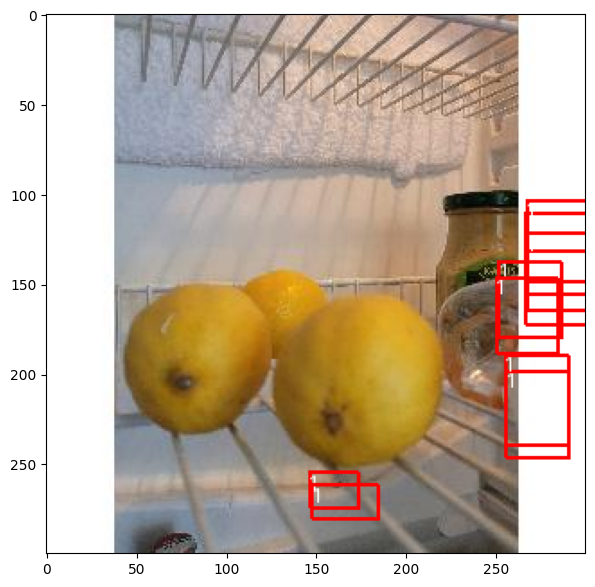

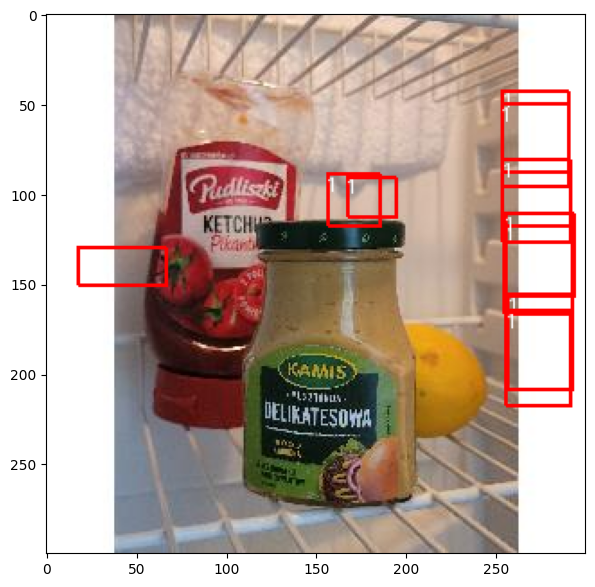

In [84]:
model2.eval()

list_img = ['20241103_122632_jpg.rf.40328055a147404628c42a0f569909af.jpg', '20241103_122804_jpg.rf.36b54be6281b6e446d0de70a7b9501fc.jpg']

def test(n=5):
    d = []
    for open_img in list_img:
        origin_img = Image.open(r"C://Users//izaol//fridge_food//jedzenie//test//images//" + open_img).convert('RGB')
        img = tsfm(origin_img)

        img = img.to(device)
        predicted_locs, predicted_scores = model2(img.unsqueeze(0))
        det_boxes, det_labels, det_scores = model2.detect_objects(predicted_locs, predicted_scores, min_score=0.8,
                                                                 max_overlap=10, top_k=10)
        
        # Filter out detections with scores below 0.95
        det_boxes = det_boxes[0]
        det_labels = det_labels[0]
        det_scores = det_scores[0]


        origin_dims = torch.FloatTensor([origin_img.width, origin_img.height, origin_img.width, origin_img.height]).unsqueeze(0)
        det_boxes = det_boxes * origin_dims


        annotated_image = origin_img
        draw = ImageDraw.Draw(annotated_image)
        
        for i in range(det_boxes.shape[0]): # Only consider detections with score >= 0.95
            box_location = det_boxes[i].tolist()
            label = det_labels[i].item()
            draw.rectangle(xy=box_location, outline='red')
            draw.rectangle(xy=list(map(lambda x: x + 1, box_location)), outline='red')
            draw.text(xy=box_location[:2], text=str(label))
        
        d.append(annotated_image)
    return d

for i in test():
    plt.figure(figsize=(7, 7))
    plt.imshow(i)

In [27]:
check_your_model(model1)


UnboundLocalError: cannot access local variable 'train_ds' where it is not associated with a value